We left off with the disturbing realization that even though we are satisfied the requirements of the sampling theorem, we still have errors in our approximating formula. We can resolve this by examining the Whittaker interpolating functions which are used to reconstruct the signal  from its samples.

Text(3.1, 0.5, '... and going...')

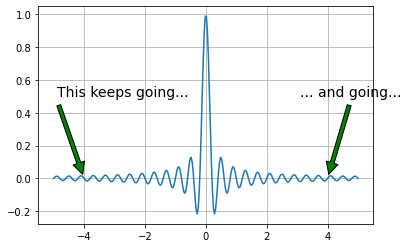

In [1]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(-5,5,300) # redefine this here for convenience

fig,ax = plt.subplots()

fs = 5.0
ax.plot(t, np.sinc(fs * t))
ax.grid()
ax.annotate('This keeps going...',
            xy=(-4,0),
            xytext=(-5+.1,0.5),
            arrowprops={'facecolor':'green','shrink':0.05},fontsize=14)
ax.annotate('... and going...',
            xy=(4,0),
            xytext=(3+.1,0.5),
            arrowprops={'facecolor':'green','shrink':0.05},fontsize=14)

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

Notice in the above plot that the function extends to infinity in either direction. This basically means that the signals we can represent must also extend to infinity in either direction which then means that we have to sample forever to exactly reconstruct the signal! So, on the one hand the sampling theorem says we only need a sparse density of samples, this result says we need to sample forever. No free lunch here!

This is a deep consequence of dealing with band-limited functions which, as we have just demonstrated, are **not** time-limited. Now, the new question is how to get these signals into a computer with finite memory. How can we use what we have learned about the sampling theorem with these finite-duration signals?

## Approximately Time-Limited Functions

Let's back off a bit and settle for functions that are *approximately*  time-limited in the sense that almost all of their energy is concentrated in a finite time-window:

$$ \int_{-\tau}^\tau |f(t)|^2 dt = E-\epsilon$$

where $E$ is the total energy of the signal:

$$ \int_{-\infty}^\infty |f(t)|^2 dt = E$$

Now, with this new definition, we can seek out functions that are band-limited but come very, very (i.e. within $\epsilon$) close to being time-limited as well. In other words, we want functions $\phi(t)$ so that they are band-limited:

$$ \phi(t) = \int_{-W}^W \Phi(\nu) e^{2 \pi j \nu t} dt $$ 

and coincidentally maximize the following:

$$ \int_{-\tau}^\tau |\phi(t) |^2 dt$$

After a lot of complicated math that I'm skipping, this eventually boils down to solving the following normalized eigenvalue equation:

$$ \int_{-1}^1 \psi(x)\frac{\sin(2\pi\beta(t-x)}{\pi(t-x)} dx = \lambda \psi(t)$$

with $\psi(t) = \phi(\tau t )$ and $\beta=\tau W$. Note that $\beta$ is proportional to the time-bandwith product. Fortunately, this is a classic problem and the $\psi$ functions turn out to be the angular prolate spheroidal wave functions. Also, it turns out that the $\phi$ functions are orthonormal on the real-line:

$$  \int_{-\infty}^\infty \phi_k(t) \phi_n(t)^*  dt = \delta_{k,n} $$

and *orthogonal* on the finite interval $[-\tau,\tau]$

$$  \int_{-\tau}^\tau \phi_k(t) \phi_n(t)^*  dt = \lambda_k \delta_{k,n} $$

This is a lot to digest at one sitting, but all we have to do here is watch the largest eigenvalue because it represents the fraction of energy contained in the interval $[-\tau,\tau]$.  In particular, we want to track the largest eigenvalue as a function of the time-bandwidth product because this will tell us for a fixed $2W$ bandwidth, how large a time-extent we must sample through in order to approximately represent signal in terms of these angular prolate spheroidal functions.

Since we have the Python-based tools at our disposal to motivate this investigation, let's look into the eigenvalues and eigenvectors of this form of the equation:

$$ \int_{-1}^1 \psi(x)\frac{\sin(2\pi\sigma(t-x)/4)}{\pi(t-x)} dx = \lambda \psi(t)$$

because it is neatly parametered by the time-bandwidth product $\sigma = (2\tau)(2W)$.

In [2]:
def kernel(x, sigma=1):
    'convenient function to compute kernel of eigenvalue problem'
    x = np.asanyarray(x)
    y = np.pi*np.where(x == 0,1.0e-20, x)
    return np.sin(sigma/2*y)/y

Now, we are ready to setup the eigenvalues and see how they change with the time-bandwidth product.

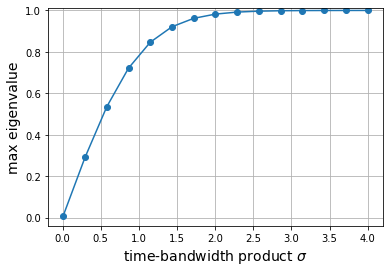

In [3]:
nstep = 100                 # quick and dirty integral quantization
t = np.linspace(-1,1,nstep) # quantization of time
dt = np.diff(t)[0]          # differential step size
def eigv(sigma):
    return np.linalg.eigvalsh(kernel(t-t[:,None], sigma)).max() # compute max eigenvalue

sigma = np.linspace(0.01,4,15) # range of time-bandwidth products to consider

fig,ax = plt.subplots()
ax.plot(sigma, dt*np.array([eigv(i) for i in sigma]),'-o')
ax.set_xlabel('time-bandwidth product $\sigma$', fontsize=14)
ax.set_ylabel('max eigenvalue', fontsize=14)
ax.axis(ymax=1.01)
ax.grid()

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

Keep in mind that this cannot actually *achieve* a maximum of one since that would mean that it *is* possible to have both time/band-limited functions (which is impossible). But, note that if you numerically achieve this than it has to do with the crude approximation to the integral that we are using.

The important part of this graph is how steep the curve is. Namely, if we have a time-bandwidth product of $3$ or more, then we have already found an eigenfunction (or, vector, in our case) that is compressed *almost* entirely into the interval $[-1,1]$. Now let's look at the corresponding eigenvector.

Text(0.5, 1.0, 'Eigenvector corresponding to e-value=9.9899e-01;$\\sigma$=3.00')

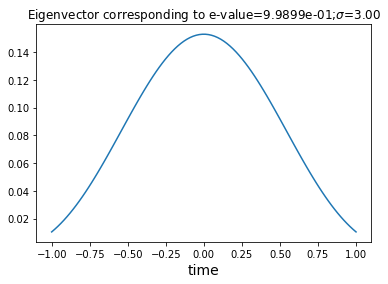

In [4]:
sigma = 3
w,v = np.linalg.eigh(kernel(t-t[:, None], sigma))
maxv = v[:, w.argmax()]
fig, ax = plt.subplots()
ax.plot(t, maxv)
ax.set_xlabel('time',fontsize=14)
ax.set_title('Eigenvector corresponding to e-value=%2.4e;$\sigma$=%3.2f'%(w.max()*dt,sigma))

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

In fact, since the angular prolate spheroidal wave functions are in `scipy.special`, we can check our crude result against a better numerical solution

Text(0.5, 1.0, 'Comparison of $0^{th}$ prolate function')

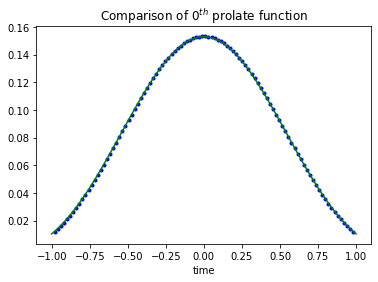

In [5]:
import scipy.special

# quick definition to clean up the function signature and normalize
def pro(t, k=0, sigma=3): 
    'normalized prolate angular spherioidal wave function wrapper'
    tmp = scipy.special.pro_ang1(0,k,np.pi/2*sigma,t)[0] #kth prolate function
    den = np.linalg.norm(tmp[np.logical_not(np.isnan(tmp))])# drop those pesky NaNs at edges
    return tmp/den # since e-vectors are likewise normalized

fig, ax = plt.subplots()

ax.plot(t, pro(t), 'b.', t, maxv, '-g');
ax.set_xlabel('time')
ax.set_title('Comparison of $0^{th}$ prolate function')


# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

Since these two lines are basically on top of each other, it implies that our extremely crude approximation to this function is actually not bad. You can play with the `nstep` variable above to see how the discrete time step influences this result.

What does this all mean?

The key fact we have demonstrated here is that when the time-bandwith product is relatively large ($\sigma>3$), then all of the signal energy in our *approximately* time-limited functions is concentrated in the zero-th prolate function. This means that any approximately time-limited function can be expanded into the basis of prolate functions in the following way:

$ f(t) = \sum_k a_k \psi_k(t)  $

where $a_0 >> a_k$ when the time-bandwidth product is bigger than three, $\sigma>3$.

What we have been exploring here is formally the result of the Landau-Pollak theorem which says that if we take $\sigma+1$ prolate functions, given a fixed $\epsilon$, then we can then reconstruct the signal with a mean-squared error ($\mathbb{L}_2$-norm) less than $12\epsilon$. Notwithstanding what the theorem says, we still must control $\epsilon$ here by expanding the time-interval over which we consider the signal. This means that the time-extent, or, duration, of the signal is what is improving the approximation. The prolate functions are a *means* to getting under this bound. The choice of the duration fixes $\epsilon$.

Let's test this bound in Python by considering our favorite band-limited function: $X(f)=1$ if $|f| < W $ and zero otherwise.


Text(0.5, 0, 'time')

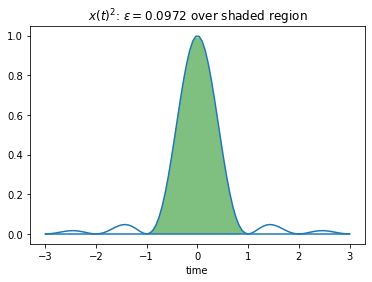

In [6]:
W = 1/2 # take bandwidth = 1 Hz. This makes the total signal power=1
# compute epsilon for this time-extent
epsilon = 1 - 2/np.pi*scipy.special.sici(2*np.pi)[0] # using sin-integral special function

fig,ax = plt.subplots()

t = np.linspace(-3,3,100)
ax.plot(t, np.sinc(t)**2)
ax.hlines(0,-3,3)
tt = np.linspace(-1,1,20)
ax.fill_between(tt,0, np.sinc(tt)**2,facecolor='g',alpha=0.5)
ax.set_title('$x(t)^2$: $\epsilon=%2.4f$ over shaded region' % epsilon)
ax.set_xlabel('time')

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

The theorem says that 

$ \int_{-\infty}^\infty | x(t) - \sum_{k=0}^{\sigma+1} a_k \psi_k(t) |^2 dt < 12 \epsilon $

which computes to 0.0972*12 = 1.1664 in our case, which is not saying much since the total energy of the signal was equal to 1 and this means that the error is on the same order as the signal itself! Let's try another band-limited function:

$X(f) = (1+f)$ if $ f \in [-1,0]$

$X(f) = (1-f)$ if $ f \in [0,1]$

and zero otherwise. This corresponds to the following time-domain function

$x(t)=\frac{\sin(\pi t)^2}{\pi^2 t^2}$

Let' quickly plot this:

Text(0.5, 0, 'time')

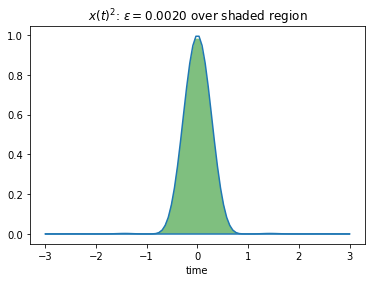

In [9]:
epsilon= 2/3. + 4/3/np.pi*scipy.special.sici(2*np.pi)[0]-8/3/np.pi*scipy.special.sici(4*np.pi)[0] # total energy is 2/3 in this case

fig,ax = plt.subplots()
t = np.linspace(-3,3,100)
ax.plot(t, np.sinc(t)**4)
ax.hlines(0,-3,3)
tt = np.linspace(-1,1,20)
ax.fill_between(tt,0, np.sinc(tt)**4, facecolor='g', alpha=0.5)
ax.set_title('$x(t)^2$: $\epsilon=%2.4f$ over shaded region' % epsilon)
ax.set_xlabel('time')

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


And in this case, $12\epsilon=0.0236$ which is a lot better, as we would expect since $x(t)$ is much more tightly concentrated in the interval $[-1,1]$.

What have we learned? If the signal is concentrated in the interval, then we don't need a large duration over which to sample it. The Landau-Pollak theorem provides specific criterion for what can expect by using prolate spheroidal wave functions that are constructed to optimize their energies in a fixed interval. The key take-away from all this is that we want large duration-bandwidth products, $ duration >> 1/bandwidth $ so that we can be assured of collecting enough signal energy in the duration.

Under the condition or large time-bandwidth products, let's reconsider our eigenvalue problem but now let's separate the $\tau$ and $W$ terms as in the following:

$ \int_{-\tau}^\tau \phi(x)\frac{sin(2\pi W (t-x)}{\pi(t-x)} dx = \lambda \phi(t)$

Text(0.5, 1.0, '$\\phi_{max}(t),\\sigma=10*2=20$')

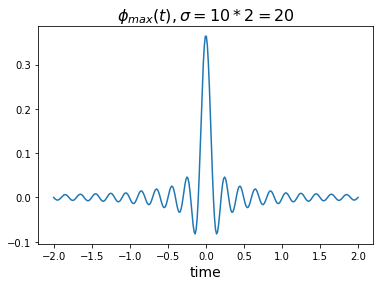

In [10]:
def kernel_tau(x,W=1):
    'convenient function to compute kernel of eigenvalue problem'
    x = np.asanyarray(x)
    y = np.pi*np.where(x == 0,1.0e-20, x)
    return np.sin(2*W*y)/y

nstep = 300                    # quick and dirty integral quantization
t = np.linspace(-1,1, nstep)    # quantization of time
tt = np.linspace(-2,2, nstep)   # extend interval

w, v = np.linalg.eig(kernel_tau(t-tt[:, None],5))
ii = np.argsort(w.real) 
maxv = v[:, w.real.argmax()].real
fig,ax = plt.subplots()
ax.plot(tt, maxv)
##plot(tt,v[:,ii[-2]].real)
ax.set_xlabel('time', fontsize=14)
ax.set_title('$\phi_{max}(t),\sigma=10*2=20$',fontsize=16)

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


This turns out to be the `sinc` function. This means that when the time-bandwidth product is large, the prolate spheroidal Wave Functions devolve into `sinc` functions in the eigenvalue problem. This means that under these conditions, it is okay to use the Whittaker interpolating functions as we used previously.

## Summary

In this section, at first blush, it may look like we accomplished nothing. We started out investigating why is it that we have some residual error in the reconstruction formula using the Whittaker approximation functions. Then, we recognized that we cannot have signals that are simultaneously time-limited and band-limited. This realization drove us to investigate "approximately" time-limited functions. Through carefully examining the resulting eigenvalue problem, we realized that the Landau-Pollak theorem provides criterion for finite-dimensionality of band-limited signals in terms of approximately time-limited optimal prolate spheroidal wave functions. However, the real profit of these results in our discussion is that we require large time-bandwidth products in order to reduce our approximation errors and under these conditions, we can legitimately use the same Whittaker interpolating functions that we started out with in the first place!  Ultimately, if we want to reduce our reconstruction errors, then we just have to sample over a longer duration since capturing the signal energy in the time domain is based on accumulating more of the signal over a longer duration.

## References


* This is in the [IPython Notebook format](http://ipython.org/) and was converted to HTML using [nbconvert](https://github.com/ipython/nbconvert).

* See [Signal analysis](http://books.google.com/books?id=Re5SAAAAMAAJ) for more detailed mathematical development.

* The IPython notebook corresponding to this post can be found [here](https://github.com/unpingco/Python-for-Signal-Processing/blob/master/Sampling_Theorem_Part_2.ipynb).